### JPLDD Demo Notebook

In [35]:
import torch
import flow_vis
import numpy as np
from matplotlib import pyplot as plt
import cv2
from torchvision.transforms import Resize
from pytlsd import lsd
import sys
import os
notebook_dir = os.getcwd()
sys.path.append(os.path.join(notebook_dir, '..'))
from gluefactory.utils.experiments import load_experiment
from gluefactory.models.extractors.jpldd.line_detection_jpldd import detect_jpldd_lines
from sklearn.decomposition import PCA

In [36]:
plt.rcParams["figure.figsize"] = (7,7)

In [37]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'
device = 'cpu'
device

'cpu'

In [38]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

torch.Size([1, 3, 800, 800])


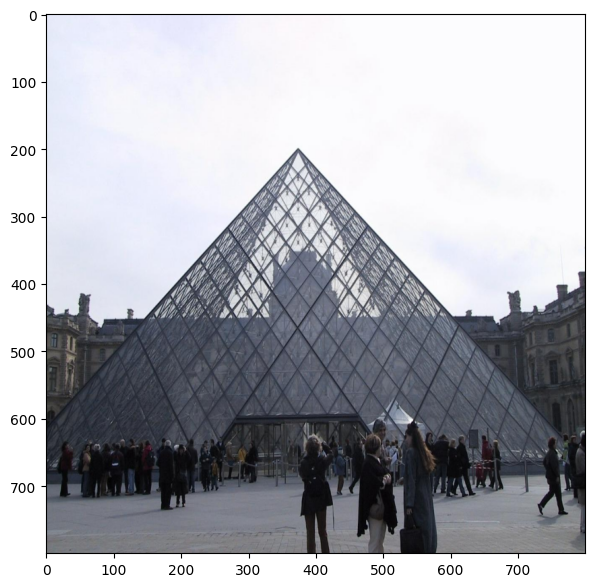

In [53]:
conf_lines = {
    "min_length": 25,
    "max_num_lines": None,
    "force_num_lines": False,
    "model_conf": {
        "detect_lines": True,
        "line_detection_params": {
            "merge": False,
            "grad_nfa": True,
            "filtering": "normal",
            "grad_thresh": 3.0,
        },
    }
}

size = (800,800)

conf_homography = {
    'translation': True,
    'rotation': True,
    'scaling': True,
    'perspective': True,
    'scaling_amplitude': 0.2,
    'perspective_amplitude_x': 0.2,
    'perspective_amplitude_y': 0.2,
    'patch_ratio': 0.85,
    'max_angle': 1.57,
    'allow_artifacts': True
}
resize_func = Resize(size)
image_path = f"demo_louvre.jpg"
img = cv2.resize(cv2.imread(image_path),size)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_torch = numpy_image_to_torch(img).to(device)
img_torch = img_torch.unsqueeze(0)

print(img_torch.shape)
plt.imshow(rgb_img)
plt.show()

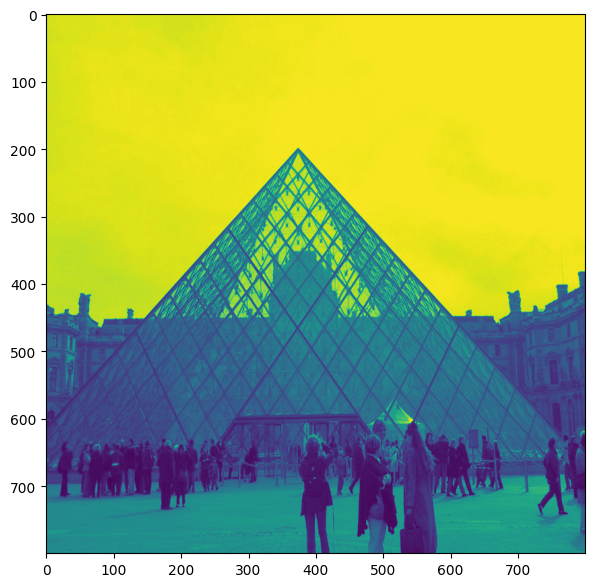

In [54]:
scale = img_torch.new_tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1).to(device)
gs_image = (img_torch * scale).sum(1, keepdim=True)
np_gs_image = gs_image.squeeze().cpu().numpy()
plt.imshow(np_gs_image)

## JPLDD Heatmaps

In [55]:
jpldd_conf = {
    "name": "jpldd.joint_point_line_extractor",
    "model_name": "aliked-n16",
    "max_num_keypoints": 1024,  # setting for training, for eval: -1
    "pretrained": True,
    "timeit": True,  # override timeit: False from BaseModel
    "train_descriptors": {
        "do": False,  # if train is True, initialize ALIKED Light model form OTF Descriptor GT
        "device": None # device to house the lightweight ALIKED model
    }
}
jpldd_model = load_experiment("jpldd_09.tar", jpldd_conf).to(device)

[06/17/2024 22:56:45 gluefactory.utils.experiments INFO] Loading checkpoint jpldd_09.tar
Load pretrained weights for aliked parts...
Load ALiked Lightweight model for descriptor training...
[06/17/2024 22:56:45 gluefactory.utils.experiments WARNING] Missing 48 parameters in aliked_lw


In [56]:
%%time

with torch.no_grad():
    output_jpldd = jpldd_model({"image": img_torch})
output_jpldd.keys()

CPU times: user 9.69 s, sys: 4.55 s, total: 14.2 s
Wall time: 1.88 s


dict_keys(['keypoint_and_junction_score_map', 'line_anglefield', 'line_distancefield', 'keypoints_raw', 'keypoints', 'keypoint_scores', 'descriptors'])

In [57]:
jpldd_kpjhm = output_jpldd['keypoint_and_junction_score_map'][0]
jpldd_af = output_jpldd['line_anglefield'][0]
jpldd_df = output_jpldd['line_distancefield'][0]
jpldd_kpr = output_jpldd['keypoints_raw'][0]
jpldd_kp = output_jpldd['keypoints'][0]
jpldd_kp_scores = output_jpldd['keypoint_scores'][0]
jpldd_desc = output_jpldd['descriptors'][0]

jpldd_kpjhm.shape, jpldd_af.shape, jpldd_df.shape, jpldd_kpr.shape, jpldd_kp.shape, jpldd_kp_scores.shape, jpldd_desc.shape

(torch.Size([800, 800]),
 torch.Size([800, 800]),
 torch.Size([800, 800]),
 torch.Size([1024, 2]),
 torch.Size([1024, 2]),
 torch.Size([1024]),
 torch.Size([1024, 128]))

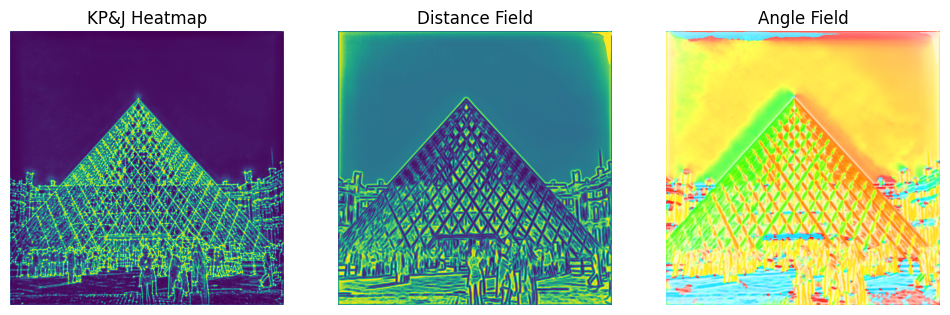

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].axis('off')
ax[0].set_title('KP&J Heatmap')
ax[0].imshow(jpldd_kpjhm)

ax[1].axis('off')
ax[1].set_title('Distance Field')
ax[1].imshow(jpldd_df)

ax[2].axis('off')
ax[2].set_title('Angle Field')
ax[2].imshow(get_flow_vis(jpldd_df, jpldd_af))
plt.show()

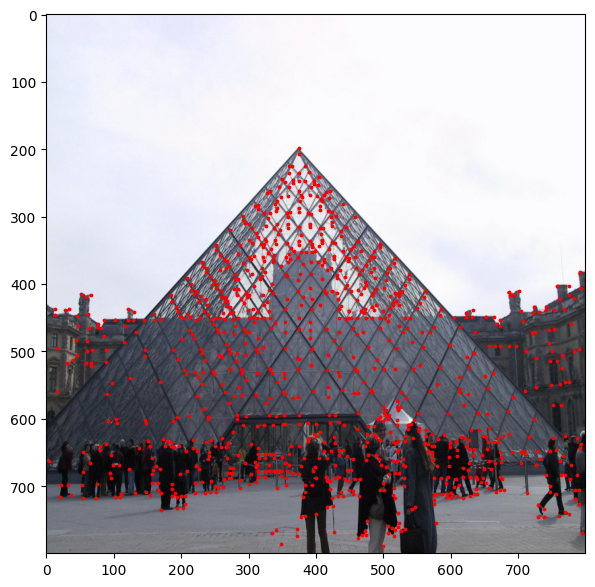

In [59]:
plt.imshow(rgb_img)
plt.scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], c='r', s=3)
plt.show()

### Descriptor visualization

In [60]:
pca = PCA(n_components=3)
pca.fit(jpldd_desc.numpy())

pca_desc = pca.transform(jpldd_desc)

normalized_pca_desc = pca_desc - pca_desc.min()
normalized_pca_desc = normalized_pca_desc / normalized_pca_desc.max()

normalized_pca_desc

array([[0.79227334, 0.38609916, 0.75795844],
       [0.79649284, 0.40309607, 0.7663549 ],
       [0.8065832 , 0.36188139, 0.79758146],
       ...,
       [0.60251196, 0.51136701, 0.26149135],
       [0.57546453, 0.54545263, 0.41676848],
       [0.49088714, 0.79832195, 0.37715958]])

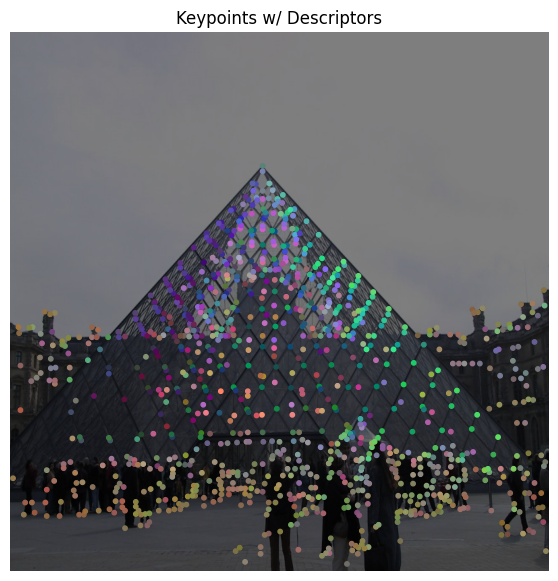

In [61]:
plt.axis('off')
plt.title('Keypoints w/ Descriptors')
plt.imshow(rgb_img)
plt.imshow(np.zeros_like(img), alpha=0.5, cmap='gray')
plt.scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], c=normalized_pca_desc, s=10)
#plt.savefig('../experiments/data/kpd.png')
plt.show()

## Line Detection

In [62]:
df = jpldd_df
af = jpldd_af
detected_lines = detect_jpldd_lines(
    df, af, jpldd_kp,
    n_samples=64, 
    df_thresh=2, 
    inlier_thresh=0.9,
    a_diff_thresh=np.pi/20,
    a_std_thresh=np.pi/10,
    r_radius = 1,
)
detected_lines.shape

torch.Size([4984, 2, 2])

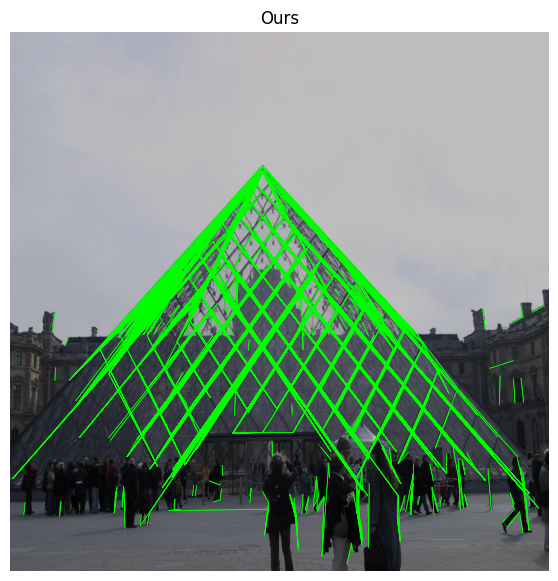

In [63]:
LINE_COLOR = 'lime'
KP_COLOR = 'r'
ALL_KP_COLOR = 'blue'

plt.title('Ours')
plt.axis('off')
# plt.imshow(npdf)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(np.zeros_like(img), alpha=0.25)
line_segs = detected_lines
valid_xs = line_segs[:, 0]
valid_ys = line_segs[:, 1]
for i in range(len(line_segs)):
    x1, x2 = valid_xs[i]
    y1, y2 = valid_ys[i]
    plt.plot([y1, y2], [x1, x2], c=LINE_COLOR, linewidth=0.5)
# plt.scatter(*junctions.T.numpy()[::-1], c=ALL_KP_COLOR, s=1)
# plt.scatter(valid_ys[:, 0], valid_xs[:, 0], c=KP_COLOR, s=5)
# plt.scatter(valid_ys[:, 1], valid_xs[:, 1], c=KP_COLOR, s=5)
# plt.scatter(lines[:1000, 0, 0], lines[:1000, 1, 0], c=KP_COLOR, s=5)
# plt.legend()
plt.show()